# Lab 3: Build a theremin

<font size="3"> Last updated May 7, 2024 </font>

## <span style="color:orange;"> 00. Content </span>

### Mathematics 
- N/A
    
### Programming Skills 
- Asynchronous functions
- Nonlocal variables
    
### Embedded Systems 
- Timing conflicts
- Buffer underflow

## <span style="color:orange;"> 0. Required Hardware </span>
- Raspberry Pi Pico
- MicroUSB cable
- Breadboard
- [I2S speaker module](https://learn.adafruit.com/adafruit-max98357-i2s-class-d-mono-amp), with [8-ohm speaker](https://www.adafruit.com/product/1890) connected
- jumper wires (at least 12)
- a potentiometer

<h3 style="background-color:lightblue"> Write your name and email below: </h3>

**Name:** me 

**Email:** me @purdue.edu

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## <span style="color:orange;"> 1. Intro </span>

In a previous lab, we made a synthesizer which works by playing precomputed samples of audio. That worked well for a synthesizer, where we only have a limited selection of notes to choose from. One of the main drawbacks of this approach is that we can't change the samples in response to user input. For example, if we wanted to play sounds with multiple waveforms at multiple volumes over a continuous range of frequencies, we would run out of memory very fast.

In this lab, we will discover some of the problems with computing samples in real time, and share some strategies for overcoming those difficulties. This will culminate in building a musical instrument which we can play without touching, called a theremin. A traditional theremin works by detecting changes in capacitance, while ours will work by monitoring the timing of ultrasound signals.

## <span style="color:orange;"> 2. The components </span>

In the previous lab we tested the MAX98357 speaker module. As a reminder, it should be wired as in this table.

| MAX 98357 | Speaker |
|-----------|---------|
| -         | (either wire) |
| +         | (the other wire) |

| MAX 98357 | Pico | What it does |
|-----------|------|--------------|
| Vin       | VBUS | USB power directly to the speaker driver |
| GND       | GND  | A shared ground           |
| BCLK      | GP16 | clock signal              |
| LRC       | GP17 | left/right channel select |
| DIN       | GP18 | data signal               |

We will use two additional pieces of hardware today -- an ultrasonic distance sensor, and a potentiometer. Connect them as in the following tables.

| Potentiometer | Pico |
|---------------|------|
| left leg      | GND  |
| right leg     | 3V3  |
| wiper leg     | GP26 |

| HC-SR04       | Pico |
|---------------|------|
| VCC           | VBUS |
| GND           | GND  |
| Trig          | GP19 |
| Echo          | GP20 |

There are many ways to accomplish these connections on a breadboard. One possible way is shown below -- note that the breadboard power rails are used to provide power and ground to the potentiometer, and the ultrasonic sensor is connected to power at the speaker module.

![a photo of a completed breadboard](wiring_small.jpg)

To test that you have everything connected correctly and your components are working as expected, the file [component_test.py](https://github.com/TheDataScienceLabs/DSLab_Fourier/blob/main/book/labs/synthesis/build_a_theremin/component_test.py) has been provided. When you run it, it should produce a stream of numbers. You should be able to change the first number by rotating the potentiometer. The second number should tell you the distance in centimeters from the ultrasonic distance sensor to the nearest hard flat object -- if no object is detected it will give `nan` instead. If either number does not change, figure out why and fix it before continuing.

## <span style="color:orange;"> 3. A naive approach </span>

There are two inputs to a Theremin. A theremin makes a pure tone with a frequency that changes from one input, and volume which changes due to the other input. Traditionally a user moves their hand over two metal probes changing the capacitance. This change in capacitance is mapped to frequency and volume at the two probes. A small distance corresponds to a high frequency or low volume, and a large distance makes a low tone or high volume at the respective probes. But instead of mapping the capacitance, we will be using an ultrasonic sensor to measure the distance and map it to a range of frequencies.

Unfortunately, it can be hard to coordinate multiple ultrasonic sensors at once, since they can hear each other. So, for volume, we will use the potentiometer instead. The highest signal we can send to the speaker is $2^{15}$ since it takes a signed 16 bit integer, and the potentiometer gives numbers between 0 and $2^{16}$ since it's an unsigned 16 bit integer. We will just take a sine curve and multiply it by the potentiometer value over 2.

Let's set a high frequency of A5=880 Hz at 1 centimeter distance, and a low frequency of C4=262 Hz at 60 cm distance. That means at the high end a period of $\frac{22050}{880} = 25 $ samples and at the low end a period of $\frac{22050}{262}=84$ samples. For simplicity, we will interpolate linearly, giving the function 

$$
\text{sample count} = 25 + (84-25)\frac{\text{distance}-1}{60-1}.
$$

We will round to the nearest integer, giving us a curve like the following.

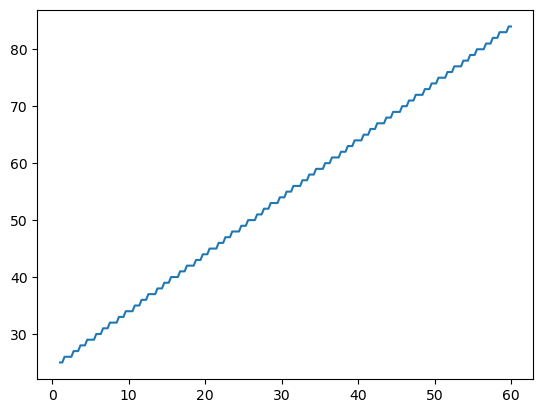

In [3]:
distance = np.linspace(1, 60, 200)
sample_count = np.rint( 25 + (84-25)*(distance-1)/(60-1) )
plt.plot(distance, sample_count)
plt.show()

Applying this strategy blindly gives us a program like [naive_theremin.py](https://github.com/TheDataScienceLabs/DSLab_Fourier/blob/main/book/labs/synthesis/build_a_theremin/naive_theremin.py). 

### <span style="color:red"> Exercise 1 </span> (10 pts)
Run [naive_theremin.py](https://github.com/TheDataScienceLabs/DSLab_Fourier/blob/main/book/labs/synthesis/build_a_theremin/naive_theremin.py) and see what happens. You will likely find that it sounds scratchy, not at all like a pure sine wave, and of a much lower pitch than we would like. Write a description of the sound in your own words. How does it respond to movement in front of the ultrasonic sensor, or changes to the potentiometer?
<h3 style="background-color:lightblue"> Write Answers for Exercise 1 Below </h3>

The problem here is in the timing between taking the input and playing it through the speaker. Run the program [naive_theremin_timed.py](https://github.com/TheDataScienceLabs/DSLab_Fourier/blob/main/book/labs/synthesis/build_a_theremin/naive_theremin_timed.py). This is almost identical, but it notes the current time before and after computing the tone. You will find that the tone takes anywhere from 2500 to 8000 microseconds to make. A 50 sample clip only takes $\frac{50 \text{samples}}{22,050\text{ samples/second}}= 2200$ microseconds to play. That means that by the time the the I2S buffer is empty, we have not even finished coming up with the next sample. This is called **buffer underflow**.

There are two ways to fix this. We can either compute the samples faster, or we can get ourselves more time to use for computing.

## <span style="color:orange;"> 4. faster computation </span>

If we want Python code to go faster, there is one approach which almost always works: remove big loops. There is just one big loop in the code which generates the tone. let's try running that code on your computer. Your computer is much faster than the microcontroller, so it will be able to do it quicker, but we can still make useful comparisons by comparing with other code running on the same computer.

The `timeit` command makes it easy to tell how long something takes to run. Let's try it on the `make_tone` function. To make the effect more visible, we'll make a tone with many more samples than we really need.

In [3]:
import math
import struct
def make_tone(samplecount, volume):
    tone = bytearray(samplecount * 2)
    for i in range(samplecount):
        sample = int(volume * math.sin(2 * math.pi * i / samplecount))
        struct.pack_into("<h", tone, 2 * i, sample)
    return tone

In [4]:
%%timeit

make_tone(6000, 2**14)

3.85 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


On my computer, it takes about 3.6 milliseconds to make a 6000-sample tone. Of course, I can do it without a loop if I just use `numpy` instead. Let's see how that would go.

In [5]:
def fast_tone(samplecount, volume):
    tone = volume * np.sin(np.linspace(0, 2*np.pi, samplecount, endpoint=False))
    return np.asarray(tone, dtype=np.int16).tobytes()

In [6]:
%%timeit

fast_tone(6000, 2**14)

91 µs ± 2.51 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


On my computer that took just 91 microseconds, or 0.091 milliseconds. The difference is tremendous.

Can we get the same benefit in Micropython? Yes, but the default firmware does not include `numpy`. We will need to install a copy of the firmware which has that package available. You could download the latest version [from this website](https://github.com/v923z/micropython-builder), or just use the version included here as [PICO.uf2](https://github.com/TheDataScienceLabs/DSLab_Fourier/blob/main/book/labs/synthesis/build_a_theremin/PICO.uf2). In either case, hold the bootloader button on your Pico while plugging it in, then copy the `uf2` file onto the drive that appears. Don't use Thonny for this, since it will use the default firmware, not one which includes `numpy`.

### <span style="color:red"> Exercise 2 </span> (10 pts)
Run the file [numpy_theremin.py](https://github.com/TheDataScienceLabs/DSLab_Fourier/blob/main/book/labs/synthesis/build_a_theremin/numpy_theremin.py). Write a description of the sound it makes, including in what ways it is different from the sound produced by [naive_theremin.py](https://github.com/TheDataScienceLabs/DSLab_Fourier/blob/main/book/labs/synthesis/build_a_theremin/naive_theremin.py).
<h3 style="background-color:lightblue"> Write Answers for Exercise 2 Below </h3>

The only difference between the two files is the function `make_tone`, which has been swapped for the function `fast_tone` above. You will find it takes only around 800 microseconds to compute the tone now, easily 5 times faster. On top of that, we get the improved readability that code written with broadcasting provides.

Unfortunately, while it is faster, it is still not fast enough. We need to get some more time in order to make this work without buffer underflow.

## <span style="color:orange;"> 5. finding more time </span>

The code we have written so far is written in a synchronous way. Execution proceeds from top to bottom, doing one line at a time. For every call to `audio_out.write`, there is one call to `make_tone`. While the code does one thing (making the tone to play) it cannot do anything else (writing the tone to the buffer). This works fine as long as there is plenty of time to go around. In our case, it means there is a problem.

The simplest way to solve this would be to change the ratio of calls to `audio_out.write` and `make_tone`, carefully including more of one or the other, and tweaking the size of the I2S buffer until we find the perfect balance. That would be tedious, and it would be hard to change. If we rewrote some code to make one part faster, we would have to rewrite the whole thing.

The solution is to use **asynchronous functions**. An asynchronous function is called by a routine which schedules tasks according to whichever needs the time most urgently. If you run the program [async_theremin.py](https://github.com/TheDataScienceLabs/DSLab_Fourier/blob/main/book/labs/synthesis/build_a_theremin/async_theremin.py), you will find it works great, with none of the clicking, stuttering, or scratching we heard previously.

### <span style="color:red"> Exercise 3 </span> (10 pts)
Run the file [async_theremin.py](https://github.com/TheDataScienceLabs/DSLab_Fourier/blob/main/book/labs/synthesis/build_a_theremin/async_theremin.py). Have some fun making spooky sounds. Just for fun, try to recreate the theremin intro sound from the original Star Trek. Once you have got it working, write a short message here to indicate that you have done so.
<h3 style="background-color:lightblue"> Write Answers for Exercise 3 Below </h3>

### Understanding the asynchronous version

Most of the code here is the same as before. There are a few differences, which we will discuss here.

```python
tone = bytes(100)

async def write_tone():
    nonlocal tone
    # ...

async def refresh_tone():
    nonlocal tone
    # ...
```

The point of the asynchronous version is to allow these two routines (getting a new tone, and writing the current tone) to run independently of one another. However, they still need a way to share information between each other. That's the point of the variable `tone`. By declaring it as `nonlocal`, we can have `refresh_tone` write to the variable and `write_tone` read from the variable.

Functions which run asynchronously need the special keyword `async` as part of their definition. This makes sure they are only called by asynchronous functions.

```python
swriter = asyncio.StreamWriter(audio_out)
while True:
    swriter.write(tone)
    await swriter.drain()
```

All the hard work of managing the buffer is done by the `StreamWriter` object. We make a new `StreamWriter`, and write the tone to it. The special keyword `await` lets the interpreter go do other things until the condition it requires is met. In this case, the `drain` condition waits until there is enough room in the buffer to write the tone again.

```python
while True:
    await asyncio.sleep(0.01)
    # ...
```

Most of the body of `refresh_tone` is exactly the same as before. The only things we have added are the `nonlocal tone` statement and the line `await asyncio.sleep(0.01)`. We have already explained what `nonlocal tone` does. The `await` statement here is not waiting for anything in particular to change, it's just waiting for a certain amount of time to pass. This gives time to the `write_tone` function to run. It's an added bonus that this keeps the tone generation loop from happening too frequently. We really won't move our hands fast enough for changes in less than a hundredth of a second to matter, and this lets the whole system do less work.

```python
asyncio.run(asyncio.gather(write_tone(), refresh_tone()))
```

This is the final change we made. This is where the asynchronous functions actually get run. `gather` combines the two tasks into one big task, and `asyncio.run` sets them both in motion. Since they both have `while True` loops in them, they will keep going forever (until you tell them to stop).

This system works so well because it allows `write_tone` to be called as many times as necessary to fill the I2S buffer, running the `refresh_tone` function only as often as needed. Because the buffer stays topped off, there is always enough time to compute the tone when we need it. All the load balancing is handled by the `asyncio` module!

### <span style="color:red"> Exercise 4 </span> (30 pts)
Make two more nonlocal variables which (respectively) count how many times `write_tone` and `refresh_tone` are called. Put a line into each of the existing functions which increases their corresponding variable by 1 every time they go. Make a third asyncronous function which runs every two seconds and prints out the number of times each of the other tasks is run. Copy your code here, and comment on the results. About how many times is `write_tone` called for every time `refresh_tone` is called?
<h3 style="background-color:lightblue"> Write Answers for Exercise 4 Below </h3>

## <span style="color:orange;"> 6. Make it your own </span>

What changes could you make to improve this theremin? Here are a few ideas:

1. Get it working with a second ultrasonic sensor, for a truly hands-free experience
2. If you listen very carefully, you may notice the theremin stepping between tones as we go from one sample count to the next. You can see why this happens by considering the graph in section 3. Find a way to get a smoother transition between tones, possibly by including more cycles in each audio clip.
3. Add another dial to control the volume of a triangle wave of the same frequency, and add the sine and triangle waves together. This gives you control of the waveform in addition to the volume and pitch, making a whole new range of sounds possible.

### <span style="color:red"> Exercise 5 </span> (40 pts)
Pick an improvement from the list above, or think of a different improvement you could make. Describe how you made your improvement, including any code you wrote.
<h3 style="background-color:lightblue"> Write Answers for Exercise 5 Below </h3>